In [ ]:
!pip install spotipy

In [61]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Ensure plots display inline in Colab
%matplotlib inline

# Set up Spotify API credentials
client_id = "insert client id here"
client_secret = "insert client secret here"


In [69]:
# Loads local data from a CSV or JSON file based on the file extension.
def load_local_data(file_path):
    try:
        if file_path.lower().endswith('.csv'):
            data = pd.read_csv(file_path, encoding='latin1')
        elif file_path.lower().endswith('.json'):
            data = pd.read_json(file_path)
        else:
            raise ValueError("Unsupported file format. Please use CSV or JSON.")
        print(f"Successfully loaded local data from {file_path}.")
        return data
    except Exception as e:
        print(f"Error loading local data: {e}")
        return pd.DataFrame()

# For each track in the list, this function calls the Spotify API to get info about the track. It returns a DataFrame with the results.
def fetch_spotify_data_for_tracks(track_names, limit=1):
    sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))
    api_data = []
    for track_name in track_names:
        try:
            results = sp.search(q=track_name, limit=limit)
            if results['tracks']['items']:
                track = results['tracks']['items'][0]
                api_data.append({
                    'track_name': track.get('name', 'n/a'),
                    'artist_name': track.get('artists', [{}])[0].get('name', 'n/a'),
                    'popularity': track.get('popularity', 0),
                    'album_name': track.get('album', {}).get('name', 'n/a'),
                    'album_type': track.get('album', {}).get('album_type', 'n/a'),
                    'release_date': track.get('album', {}).get('release_date', 'n/a'),
                    'track_url': track.get('external_urls', {}).get('spotify', 'n/a')
                })
            else:
                print(f"No API results for track: {track_name}")
        except Exception as e:
            print(f"Error fetching data for track '{track_name}': {e}")
    return pd.DataFrame(api_data)

# Prints basic summary statistics of a DataFrame.
def summarize_data(df, label="Data"):
    print(f"\n{label} Summary:")
    print("Number of records:", df.shape[0])
    print("Number of columns:", df.shape[1])
    if not df.empty:
        print("\nSample of data:")
        print(df.head())

# Prints summary statistics and a correlation matrix for numeric columns.
def analyze_data(df, plot=False):
    print("\nSummary Statistics:")
    print(df.describe(include='all'))

    numeric_cols = df.select_dtypes(include=['int64', 'float64'])
    if not numeric_cols.empty:
        print("\nCorrelation Matrix:")
        print(numeric_cols.corr())
    else:
        print("\nNo numeric columns available for correlation analysis.")

    if plot and 'popularity' in df.columns:
        plt.figure()
        df['popularity'].hist(bins=10)
        plt.title("Popularity Distribution")
        plt.xlabel("Popularity")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

# Saves the DataFrame in the chosen file format.
def save_data(df, output_format="sqlite", output_file=None):
    try:
        if output_format == "sqlite":
            db_name = output_file if output_file else "spotify_data.db"
            conn = sqlite3.connect(db_name)
            df.to_sql('songs', conn, if_exists='replace', index=False)
            conn.commit()
            conn.close()
            print(f"Data successfully saved to SQLite database: {db_name}")
        elif output_format == "csv":
            csv_file = output_file if output_file else "transformed_data.csv"
            df.to_csv(csv_file, index=False)
            print(f"Data successfully saved to CSV file: {csv_file}")
        elif output_format == "json":
            json_file = output_file if output_file else "transformed_data.json"
            df.to_json(json_file, orient='records', lines=True)
            print(f"Data successfully saved to JSON file: {json_file}")
        else:
            print("Unsupported output format specified.")
    except Exception as e:
        print(f"Error saving data: {e}")


In [70]:
# Set the local file path for your data (CSV or JSON)
local_file = 'spotify_2023.csv'

# User input to choose the output format (sqlite, csv, or json)
output_format = input("Enter desired output format (sqlite, csv, json): ").strip().lower()

# User input to choose an output file name; press Enter for default.
output_file = input("Enter output file name (press Enter to use default): ").strip()
if output_file == "":
    output_file = None

# Display a histogram for 'popularity'
plot_flag = True


Enter desired output format (sqlite, csv, json): csv
Enter output file name (press Enter to use default): 


In [71]:
# Load local data using the load_local_data function
local_data = load_local_data(local_file)


Successfully loaded local data from spotify_2023.csv.


In [72]:
# Fetch Spotify API data for all unique tracks from the local data
if not local_data.empty:
    unique_tracks = local_data['track_name'].unique()
    api_df = fetch_spotify_data_for_tracks(unique_tracks, limit=1)
    print("Successfully fetched API data for multiple tracks.")
else:
    api_df = pd.DataFrame()


Successfully fetched API data for multiple tracks.


In [73]:
# Merge the local and API data on 'track_name'
combined_data = pd.merge(local_data, api_df, on='track_name', how='left')

# We change the 'streams' column to numbers and fill in any missing values in columns like 'key' and 'in_shazam_charts'
if 'streams' in combined_data.columns:
    combined_data['streams'] = pd.to_numeric(combined_data['streams'], errors='coerce')
if 'key' in combined_data.columns:
    combined_data['key'] = combined_data['key'].fillna('n/a')
if 'in_shazam_charts' in combined_data.columns:
    combined_data['in_shazam_charts'] = combined_data['in_shazam_charts'].fillna('0')



Original Local Data Summary:
Number of records: 953
Number of columns: 24

Sample of data:
                            track_name    artist(s)_name  artist_count  \
0  Seven (feat. Latto) (Explicit Ver.)  Latto, Jung Kook             2   
1                                 LALA       Myke Towers             1   
2                              vampire    Olivia Rodrigo             1   
3                         Cruel Summer      Taylor Swift             1   
4                       WHERE SHE GOES         Bad Bunny             1   

   released_year  released_month  released_day  in_spotify_playlists  \
0           2023               7            14                   553   
1           2023               3            23                  1474   
2           2023               6            30                  1397   
3           2019               8            23                  7858   
4           2023               5            18                  3133   

   in_spotify_charts    stream

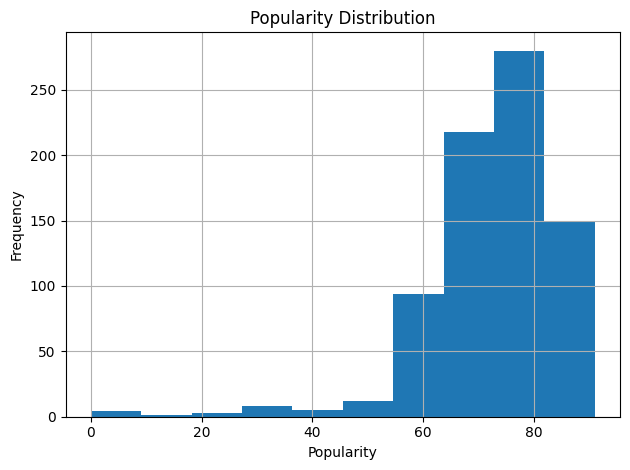

In [74]:
# Summarize original local data
summarize_data(local_data, label="Original Local Data")

# Summarize transformed data
summarize_data(combined_data, label="Transformed Data")

# Analyze the transformed data
analyze_data(combined_data, plot=plot_flag)


In [75]:
# Save the transformed data in the chosen format
save_data(combined_data, output_format=output_format, output_file=output_file)


Data successfully saved to CSV file: transformed_data.csv
